In [1]:
# merge two recordings (BL and stimulation) from the same population
# load both datasets, pre-process separately, detect spikes, 
# cluster separately, cluster average spike from BL with average spike from stim

In [2]:
from NewLibraryENG import *

In [3]:
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string_BL='/Users/Gaia_1/Desktop/h5files/'+name_data_BL
complete_string_st='/Users/Gaia_1/Desktop/h5files/'+name_data_st

In [4]:
#Baseline
data = h5py.File(complete_string_BL,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_BL = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_BL.shape)

(5020000, 60)


In [5]:
# Stimulation
data = h5py.File(complete_string_st,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_st = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_st.shape)

(4228000, 60)


In [6]:
inizio=0
len_data=1920000 #192 secondi
#len_data=len(readings)
ref_BL=readings_BL[b'Ref']
ref_st=readings_st[b'Ref']
prova_BL=readings_BL.drop([b'Ref'],axis=1)
prova_st=readings_st.drop([b'Ref'],axis=1)
prova_BL=prova_BL.iloc[inizio:len_data, 1:4]
prova_BL=prova_BL[b'46']
prova_st=prova_st.iloc[inizio:len_data, 1:4]
prova_st=prova_st[b'46']
ref_BL=ref_BL[inizio:len_data]
ref_st=ref_st[inizio:len_data]

print(prova_BL.shape,ref_BL.shape,prova_st.shape,ref_st.shape)
prova_BL

(1920000,) (1920000,) (1920000,) (1920000,)


0          -99
1         -122
2         -177
3         -147
4          -30
          ... 
1919995     32
1919996     43
1919997     59
1919998   -264
1919999      1
Name: b'46', Length: 1920000, dtype: int32

In [7]:
prova_st

0           71
1          -36
2           -5
3           81
4          118
          ... 
1919995    106
1919996     30
1919997    -54
1919998     20
1919999     35
Name: b'46', Length: 1920000, dtype: int32

In [8]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
filt_prova=filtfilt(b,a,prova_BL)
f_prova = filt_prova - filt_ref
prova_BL=f_prova

filt_ref=filtfilt(b,a,ref_st)
filt_prova=filtfilt(b,a,prova_st)
f_prova = filt_prova - filt_ref
prova_st=f_prova

print(prova_BL.shape,prova_st.shape)

(1920000,) (1920000,)


#BL
prova=prova_BL

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova_BL=filt_prova
prova_BL.shape

#stim
prova=prova_st

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_st)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova_st=filt_prova
prova_st.shape

In [10]:
prova_st

array([  1.0551707 , -80.85895893, -27.29561442, ..., -29.43280591,
        -7.6043887 ,  -2.26521391])

In [9]:
prova_st.index+=1920000
prova_st.index

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
mer=pd.concat([prova_BL,prova_st],axis=0)
mer

In [46]:
mer.index

RangeIndex(start=0, stop=3840000, step=1)

In [13]:
switch_index=1920000

In [12]:
merge=np.concatenate((prova_BL, prova_st), axis=0)
len(merge)

3840000

In [14]:
pos, neg=find_all_spikes(merge)

  0%|          | 0/3830000 [00:00<?, ?it/s]

positive spikes 7964 negative spikes 50243 detected spikes: 58207 firing rate:  151.58072916666666


prova=prova_BL
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind_BL.append(pos)
    neg_ind_BL.append(neg)

prova=prova_st
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind_st.append(pos)
    neg_ind_st.append(neg)

In [15]:
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,merge)

In [16]:
pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

pos_cut=[]
neg_cut=[]
n_pos=[]
n_neg=[]

for i,electrode in enumerate(tqdm(prova.columns)):
    pos=pos_ind[i]
    neg=neg_ind[i]
    channel=prova[electrode]
    pos_cut1,n_pos1, neg_cut1,n_neg1 = cut(pos,neg,channel)
    pos_cut.append(pos_cut1)
    neg_cut.append(neg_cut1)
    n_pos.append(n_pos1)
    n_neg.append(n_neg1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

for i in (tqdm(range(len(pos_cut)))):
    pos_cut[i]=mask_cuts(pos_cut[i])
    neg_cut[i]= mask_cuts(neg_cut[i])

final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters=clus(pos_cut[channel],'kmeans',n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)

In [20]:
spike_list=n_pos
spike_list
print(switch_index,max(spike_list))

1920000 3836137


In [48]:
spike_list=np.array(spike_list)
spike_list1=[]
for spike_ind in tqdm(spike_list):
    if spike_ind<=switch_index:
        spike_list1.append(spike_ind)
spike_list1=np.array(spike_list1)
end_spikelist1=len(spike_list1)-1
spike_list2=spike_list[end_spikelist1+1:]

  0%|          | 0/7964 [00:00<?, ?it/s]

In [50]:
len(pos_cut)

7964

In [54]:
pos_cut.shape

(7964, 30)

In [57]:
len(spike_list1)

6054

In [58]:
pos_cut[:end_spikelist1+1].shape

(6054, 30)

  0%|          | 0/7964 [00:00<?, ?it/s]

Total spikes cut1:  6053
Total spikes cut2:  1910
For 3 clusters, the silhouette score is: 0.159 0.176
For 4 clusters, the silhouette score is: 0.198 0.193
For 5 clusters, the silhouette score is: 0.214 0.208
For 6 clusters, the silhouette score is: 0.259 0.227
For 7 clusters, the silhouette score is: 0.286 0.218
For 8 clusters, the silhouette score is: 0.293 0.198
For 9 clusters, the silhouette score is: 0.308 0.207
For 10 clusters, the silhouette score is: 0.291 0.191
For 11 clusters, the silhouette score is: 0.274 0.183
For 12 clusters, the silhouette score is: 0.265 0.184
For 13 clusters, the silhouette score is: 0.248 0.169
For 14 clusters, the silhouette score is: 0.254 0.164


Best cluster in the range 3 to  14 :  9 , with a silhouette score of:  0.5145216919787241   




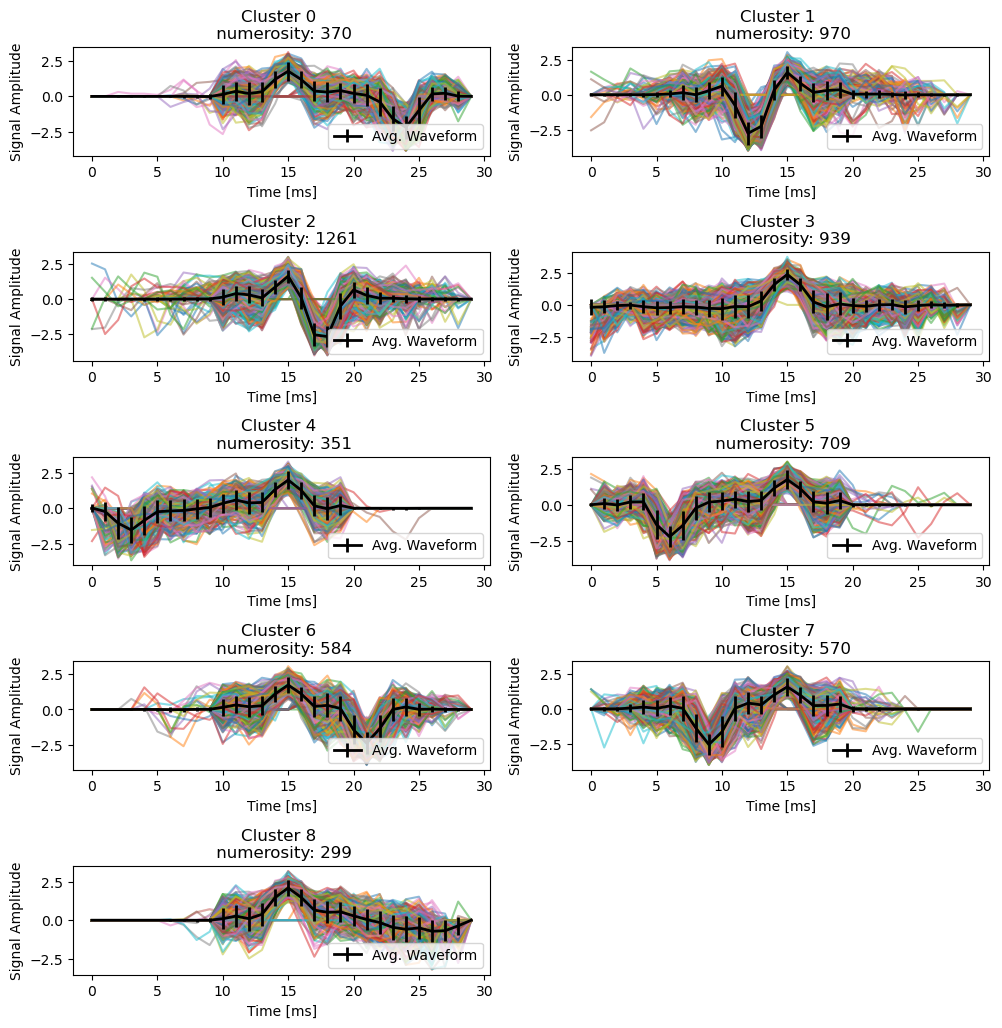

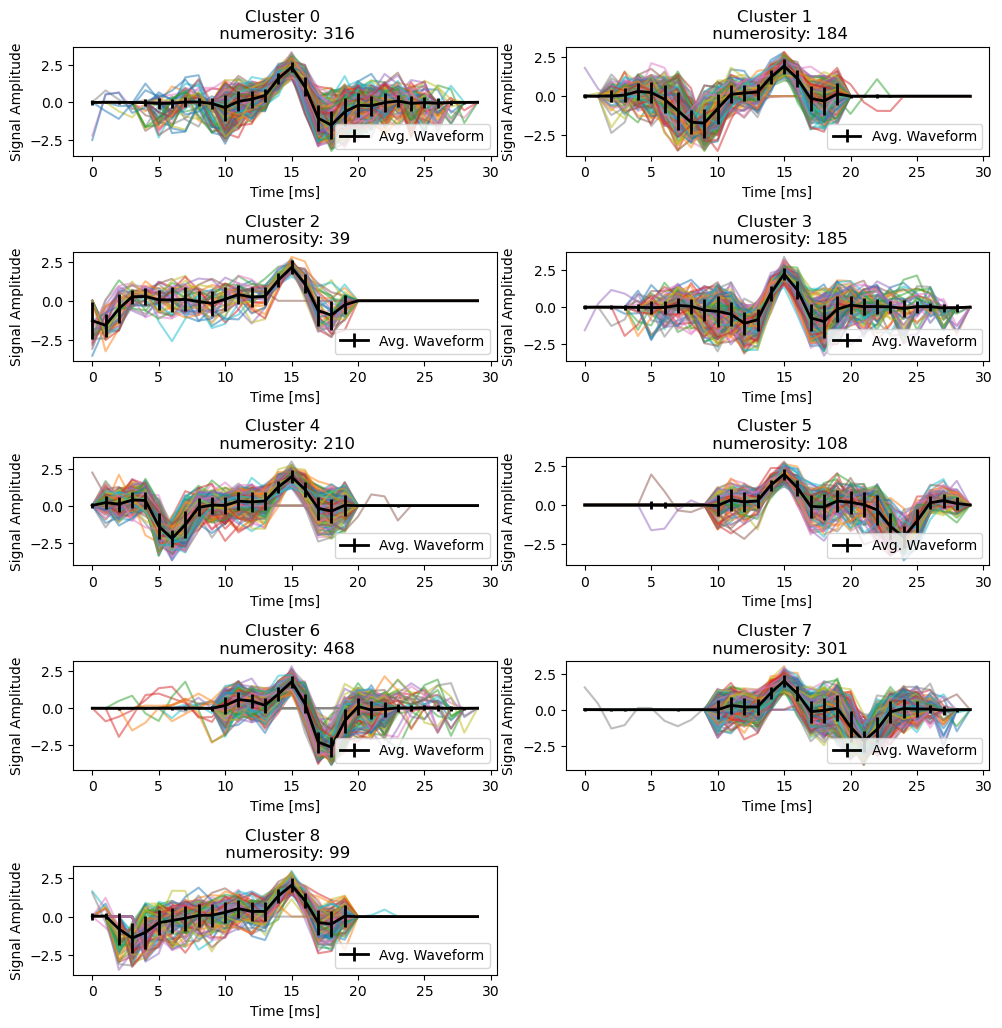

In [66]:
#def clus(cut,clustering,spike_list,data):
cut=pos_cut
clustering='kmeans'
spike_list=n_pos
data=merge
#switch_index=
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.stats import kurtosis
import skfuzzy as fuzz
import numpy as np
import math
n_min=3
n_tries=15
spike_list=np.array(spike_list)
spike_list1=[]
for spike_ind in tqdm(spike_list):
    if spike_ind<=switch_index:
        spike_list1.append(spike_ind)
spike_list1=np.array(spike_list1)
end_spikelist1=len(spike_list1)-1
spike_list2=spike_list[end_spikelist1+1:]

len_data1=len(data[:switch_index])
len_data2=len(data[switch_index+1:])

cut1=pos_cut[:end_spikelist1]
cut2=pos_cut[end_spikelist1+1:]

scale = StandardScaler()
estratti_norm = scale.fit_transform(cut1)
print('Total spikes cut1: ', estratti_norm.shape[0])
n_comp=10
pca = PCA(n_components=n_comp)
transformed1 = pca.fit_transform(estratti_norm)

estratti_norm = scale.fit_transform(cut2)
print('Total spikes cut2: ', estratti_norm.shape[0])
n_comp=10
pca = PCA(n_components=n_comp)
transformed2 = pca.fit_transform(estratti_norm)


info1=[]
info2=[]
#list_score=[]
#DB_score=[]
best_score=[]
if clustering=='kmeans':
    for n in range (n_min,n_tries):
        model = KMeans(n_clusters=n, n_init='auto', copy_x=True, algorithm='lloyd')
        labels1 = model.fit_predict(transformed1)
        labels2 = model.fit_predict(transformed2)
        if (n != 1):
            silhouette_avg1 = silhouette_score(transformed1, labels1)
            silhouette_avg2 = silhouette_score(transformed2, labels2)
            print("For", n,"clusters, the silhouette score is:", format(silhouette_avg1, ".3f"), format(silhouette_avg2, ".3f"))
            best_score.append(silhouette_avg1+silhouette_avg2)
            #del(model)
            #del(labels)
    top_clusters = (best_score.index(max(best_score)))+n_min
    num_clusters=top_clusters
    print("\n\n\033[1;31;47mBest cluster in the range", n_min, "to ", n_tries-1, ": ",top_clusters,", with a silhouette score of: ",best_score[top_clusters-n_min], "\u001b[0m  \n\n")

    model = KMeans(n_clusters=top_clusters, n_init='auto', copy_x=True, algorithm='lloyd')
    labels1 = model.fit_predict(transformed1)
    labels2 = model.fit_predict(transformed2)
######################### 
#adesso abbiamo due clusterizzazioni con lo stesso numero di cluster e bisogna accoppiarli per identificare i neuroni

#primo clustering
final_data=[]
temporary_data=[]
labels=labels1
cut=cut1
unique_labels = np.unique(labels)
firings=np.zeros(len(unique_labels))

fig = plt.figure(figsize=(10, 12))

# Iterate over unique cluster labels
for i, cluster_label in enumerate(unique_labels):
    # Extract data points for the current cluster
    cluster_data = cut[labels == cluster_label]
    firings[i]=len(cluster_data)*10000/len_data

    # Plot the individual cluster data
    if len(unique_labels)<=2:
        size1=len(unique_labels)
        size2=1
    elif len(unique_labels)<=5:
        size1 = math.ceil(len(unique_labels)/2)
        size2=size1
    elif len(unique_labels)<=8:
        size1 = 3
        size2=math.ceil(len(unique_labels)/size1)
    else:
        size1=6
        size2=math.ceil(len(unique_labels)/size1)
    plt.subplot(size1,size2, i + 1)
    plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
    #print(cluster_data)
    plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Signal Amplitude')

    # Plot the average waveform
    mean_wave = np.mean(cluster_data, axis=0)
    #info.append(f'mean clus{cluster_label}')
    info1.append(mean_wave)
    std_wave = np.std(cluster_data, axis=0)
    plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
    plt.legend(loc='lower right')
plt.tight_layout()

####secondo clustering
final_data=[]
temporary_data=[]
labels=labels2
cut=cut2
unique_labels = np.unique(labels)
firings=np.zeros(len(unique_labels))

fig = plt.figure(figsize=(10, 12))

# Iterate over unique cluster labels
for i, cluster_label in enumerate(unique_labels):
    # Extract data points for the current cluster
    cluster_data = cut[labels == cluster_label]
    firings[i]=len(cluster_data)*10000/len_data

    # Plot the individual cluster data
    if len(unique_labels)<=2:
        size1=len(unique_labels)
        size2=1
    elif len(unique_labels)<=5:
        size1 = math.ceil(len(unique_labels)/2)
        size2=size1
    elif len(unique_labels)<=8:
        size1 = 3
        size2=math.ceil(len(unique_labels)/size1)
    else:
        size1=6
        size2=math.ceil(len(unique_labels)/size1)
    plt.subplot(size1,size2, i + 1)
    plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
    #print(cluster_data)
    plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Signal Amplitude')

    # Plot the average waveform
    mean_wave = np.mean(cluster_data, axis=0)
    #info.append(f'mean clus{cluster_label}')
    info1.append(mean_wave)
    std_wave = np.std(cluster_data, axis=0)
    plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
    plt.legend(loc='lower right')
plt.tight_layout()

########### cambiato fino a qua


In [68]:
len(info1)

18

In [74]:
##qua bisogna creare le coppie


model = KMeans(n_clusters=9, n_init='auto', copy_x=True, algorithm='lloyd')
labels = model.fit_predict(info1)
        
final_data=[]
temporary_data=[]
#labels=labels2
cut=info1
unique_labels = np.unique(labels)
firings=np.zeros(len(unique_labels))

fig = plt.figure(figsize=(10, 12))
print(labels,unique_labels)
# Iterate over unique cluster labels
for i, cluster_label in enumerate(unique_labels):
    # Extract data points for the current cluster
    cluster_data = cut[labels == cluster_label]
    firings[i]=len(cluster_data)*10000/len_data

    # Plot the individual cluster data
    if len(unique_labels)<=2:
        size1=len(unique_labels)
        size2=1
    elif len(unique_labels)<=5:
        size1 = math.ceil(len(unique_labels)/2)
        size2=size1
    elif len(unique_labels)<=8:
        size1 = 3
        size2=math.ceil(len(unique_labels)/size1)
    else:
        size1=6
        size2=math.ceil(len(unique_labels)/size1)
    plt.subplot(size1,size2, i + 1)
    plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
    #print(cluster_data)
    plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Signal Amplitude')

    # Plot the average waveform
    mean_wave = np.mean(cluster_data, axis=0)
    #info.append(f'mean clus{cluster_label}')
    info1.append(mean_wave)
    std_wave = np.std(cluster_data, axis=0)
    plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
    plt.legend(loc='lower right')
plt.tight_layout()


[5 6 4 2 1 3 0 7 2 2 7 8 2 3 5 4 0 1] [0 1 2 3 4 5 6 7 8]


TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x1200 with 0 Axes>

In [ ]:
mean_firing=np.mean(firings)
std_firing=np.std(firings)
firing_threshold=mean_firing-std_firing
print('firing rate threshold: ',firing_threshold)
info.append('firing threshold')
info.append(firing_threshold)
info.append('mean firing')
info.append(mean_firing)
plt.subplots_adjust(hspace=0.5)
plt.show()

for i in range(0,len(unique_labels)):
    ul=spike_list[labels==i]
    temporary_data.append(ul)
    fr=len(temporary_data[i])*10000/len_data
    if i != -1 and fr>firing_threshold:
        final_data.append(ul)
    plt.subplot(size1, size2, i + 1)
    plt.hist(np.diff(ul), bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')
    plt.title(f'ISI: Cluster {i} \n numerosity: {len(temporary_data[i])}, \n firing rate: {format(len(temporary_data[i])*10000/len_data, ".3f")}')
plt.subplots_adjust(hspace=2.5)
plt.show()
del(unique_labels)
return final_data


Total spikes:  7964
For 3 clusters, the silhouette score is: 0.154
For 4 clusters, the silhouette score is: 0.186
For 5 clusters, the silhouette score is: 0.225
For 6 clusters, the silhouette score is: 0.251
For 7 clusters, the silhouette score is: 0.274
For 8 clusters, the silhouette score is: 0.273
For 9 clusters, the silhouette score is: 0.282
For 10 clusters, the silhouette score is: 0.254
For 11 clusters, the silhouette score is: 0.233
For 12 clusters, the silhouette score is: 0.239
For 13 clusters, the silhouette score is: 0.248
For 14 clusters, the silhouette score is: 0.233


Best cluster in the range 3 to  14 :  9 , with a silhouette score of:  0.28167904485101714   


firing rate threshold:  1.2989481342902032


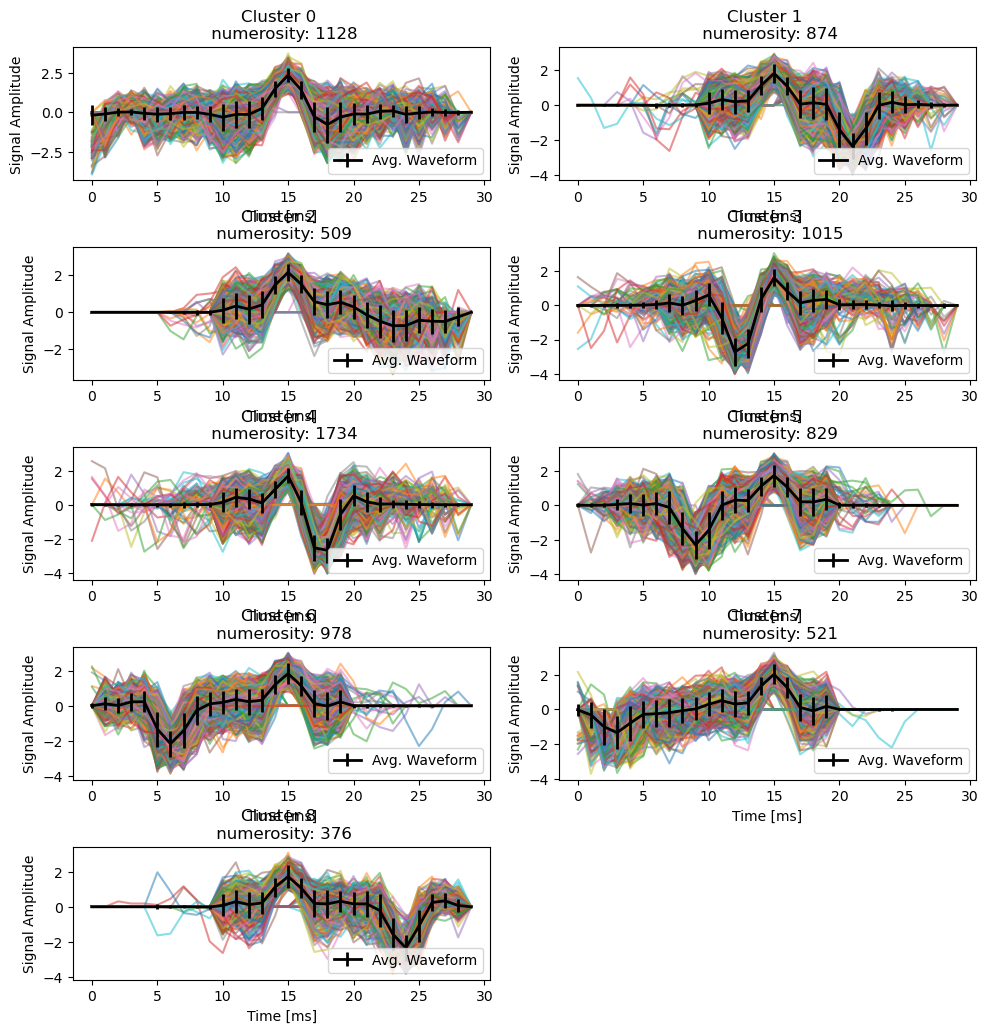

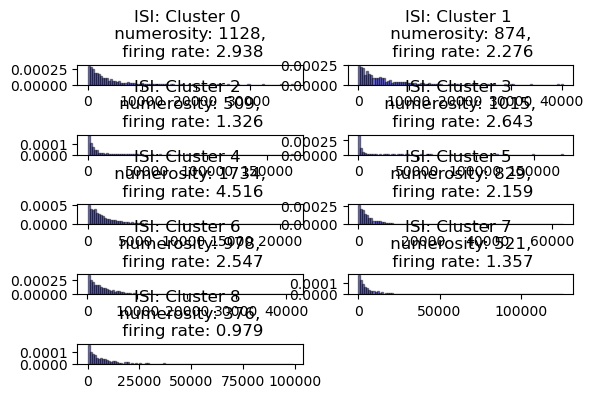

In [17]:
final_data_pos= clus(pos_cut,'kmeans',n_pos,merge)

In [54]:
final_data_neg=[]

for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters=clus(neg_cut[channel],'kmeans',n_neg[channel],prova.iloc[:,channel])
    final_data_neg.append(channel_clusters)

  0%|          | 0/3 [00:00<?, ?it/s]

Total spikes:  50506


KeyboardInterrupt: 